# LVM Data Simulator tutorial: create your own source field

**This tutorial is focused mainly on how to simulate the nebular component as an input for the LVM Data Simulator**
We consider here two examples. One is for very simplified nebulae (useful if you don't worry about the gas kinematics and variations of the line ratios). Second example describes the more complicated case and consider the usage of the various models and varying kinematics.
- The main steps on how to install, configure and run the code are considered in the [tutorial #1](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial1.ipynb).
- More details on the setup of LVM instrumentation and interpretation of the outputs of the lvmdatasimulator are given in [tutorial #3](https://github.com/sdss/lvmdatasimulator/examples/LVM_data_simulator_tutorial3.ipynb)
**N.B.: This is not ready yet, will be published soon!**



_Last update: 2022/05/19_

## Prepare everything

We assume you have *lvmdatasimulator* properly installed and configured. See the first tutorial for details.

In [1]:
# === Don't forget to set up your work directory
import os

import numpy as np

os.chdir('/Users/mors/Science/LVM/Simulator_example/')

In [2]:
# === Import everything related to lvmdatasimulator and other libraries used in this tutorial
from lvmdatasimulator.field import LVMField
from lvmdatasimulator.observation import Observation
from lvmdatasimulator.telescope import LVM160
from lvmdatasimulator.instrument import LinearSpectrograph
from lvmdatasimulator.simulator import Simulator
from lvmdatasimulator.fibers import FiberBundle

import astropy.units as u
from astropy.io import fits
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch, LinearStretch
from matplotlib import pyplot as plt

We will not change the instrumentation setup in this tutorial, so can initialize the necessary components here at once

In [3]:
tel = LVM160()
spec = LinearSpectrograph()
# we moderately limit the number of fibers to speed up the calculations.
bundle = FiberBundle(bundle_name='full', nrings=8)

[WARNING]: nrings is defined. It will limit the number of fibers selected.
[INFO]: Using the full hexagon pattern
[INFO]: Using the inner 8 exagonal rings.



## Example 1: Simulate simple nebulae

In this example we simulate the nebulae that doesn't show any variations of line profile, neither of the line ratios.
These simulations will be run fast, but physically the models are not meaningful.
**Meanwhile, such simplified case might be useful as an alternative to the ETC.**

### Step 1: Initialize field of view

We should set up the important parameters of your observations. Namely:
- RA and Dec of the center of FOV
- Size of your FOV in arcminutes (**Note: you can use any other angular units, if necessary**) *[default = 35 arcmin]*
- Size of the pixel in arcseconds *[default = 1 arcsec]*

Also there are several optional parameters defining properties of the ISM. These values will be used for each nebula in your ISM unless you provide them separately for a particular nebula:
- Distance (to calculate the conversion from pixels and arcseconds to physical scale and vice versa) *[default = 50 kpc]*
- Systemic velocity *[default = 0 km/s]*
- Turbulent velocity dispersion (used to broaden the line profile) *[default = 20 km/s]*
- Preserve_kinematics *[default = False]* - this flag is used to indicate whether you worry about gas kinematics in this simulation. If yes - the initial line profiles will be better sampled, but the cost is the longer computational time

Also, we define the units used for the spatial coordinates. There is no needs to provide the units for other parameters (but they can be explicitly defined)

*You have to initialize __LVMField__ before adding any stars or nebulae to your model.*

In [4]:
ra = 12.34 # u.degree
dec = -20.35 # u.degree
fov_size = 30 # u.arcmin
fov_pixel = 1 # u.arcsec
distance = 50 # * u.kpc
sys_vel = 0 #* u.km / u.s
turbulent_sigma = 20 #* u.km / u.s
preserve_kinematics = False

unit_ra = u.degree
unit_dec = u.degree
unit_size = u.arcmin
unit_pixel = u.arcsec

Define your field of view, initialize telescope, spectrograph and observations properties

In [5]:
my_lvmfield = LVMField(ra=ra, dec=dec, size=fov_size, spaxel=fov_pixel, name='LVM_simple_example',
                       unit_ra=unit_ra, unit_dec=unit_dec, unit_size=unit_size, unit_spaxel=unit_pixel,
                       ism_params={'distance': distance, 'sys_velocity': sys_vel, 'turbulent_sigma': turbulent_sigma,
                                   'preserve_kinematics': preserve_kinematics})

**Note:** there is no needs to provide most of parameters if you use default values. I.e. with the same effect as above you can set up __LVMField__ as


In [55]:
my_lvmfield = LVMField(ra, dec, fov_size, fov_pixel, name='LVM_simple_example')

### Step 2. Add ISM and stars to your model
Our simple example will consist of the following components:
- Stars fetched from GAIA catalogue
- Diffuse ionized gas (DIG) filling whole FOV.
- Background early-type galaxy with Sersic profile and no emission lines
- Three emission-line nebulae of different simple shape: Ellipse, Rectangle and Filament. Filament will also emit in continuum.
- Dark absorbing nebula defined as a Circle

#### Add stars (from GAIA and user-defined)
First, we add stars brighter than 15mag to our LVMField from the GAIA catalogue

In [6]:
my_lvmfield.generate_gaia_stars(gmag_limit=15)

[INFO]: 525 Gaia stars in the field
[INFO]: 500 stars are fainter than 15 and have been rejected
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
 64% (16 of 25) |###############         | Elapsed Time: 0:00:00 ETA:   0:00:00

INFO: Query finished. [astroquery.utils.tap.core]


100% (25 of 25) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
[INFO]: Rescaling 25 synthetic spectra.
[INFO]: Saving star list to: ./LVM_simple_example_starlist.fits.gz
[WARNING]: The file ././LVM_simple_example_starlist.fits.gz already exist and it will be overwritten


We can also add stars manually providing their parameters (RA, Dec, g-magnitude, effective temperature, extinction in g filter, LOS velocity).
Stellar spectra from with the closest parameters the templates will be attached to the stars.

**N.B. In the current version this will overwrite the previously fetched stars. This will be fixed soon**

In [56]:
my_additional_stars = {'ra': [12.33, 12.31, 12.30], 'dec': [-20.34, -20.37, -20.40], 'gmag': [12, 15, 17],
                       'teff': [30000, 35000, 40000], 'ag': [0.04, 0.05, 0.06], 'v': [50, 70, 90]}

my_lvmfield.generate_single_stars(parameters=my_additional_stars)

[INFO]: star 1 with Teff 30000, Gmag 12 and velocity 50 added at position (12.33 , -20.34)
[INFO]: star 2 with Teff 35000, Gmag 15 and velocity 70 added at position (12.31 , -20.37)
[INFO]: star 3 with Teff 40000, Gmag 17 and velocity 90 added at position (12.3 , -20.4)
[INFO]: Transforming world coordinates to pixel coordinates
[INFO]: Associating spectra to stars using library pollux_resampled_v0.fits...
100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
[INFO]: Rescaling 3 synthetic spectra.


Let's take a look to what we already have in our FOV:

[WARNING]: Bundle center coords are not defined, using the coords of the field.


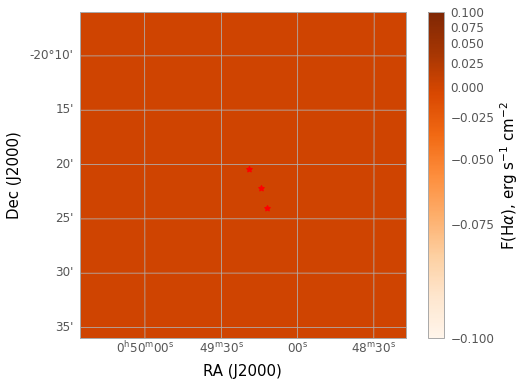

In [57]:
my_lvmfield.show()

Now, it is time to generate the nebulae to our FOV. First, we want to add DIG component which will fill whole FOV.
We will produce also correlated inhomogeneities in its brightness distribution defined by relative amplitude and spatial scale. You can set these parameters to zero if you want to see a homogeneous distribution.

**For every nebulae ``max_brightness`` corresponds to the H$\alpha$ surface brightness in the brightest part of the nebula.** By default, it is in $erg/s/cm^2/arcsec^2$, but can be expressed in the equivalent units (in that case the values should be multiplied to the corresponding astropy.units). All other parameters requiring the units (distance, sizes, scales, angles, velocities etc.) also can be defined as numbers or with explicitly mentioned astropy.units.

#### Diffuse ionized gas

In [58]:
dig = {"type": 'DIG', 'max_brightness': 2e-16, 'perturb_amplitude': 0.1, 'perturb_scale': 500 * u.pc}

In [65]:
my_lvmfield.add_nebulae(dig)

[INFO]: Start generating 1 nebulae
100% (1 of 1) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


Note the warning saying that the default cloudy model is used to produce the nebula. We will be back to this in the second example.
But now let's see what we get after adding DIG. Note that you can choose colormap and percentile interval to display the image.
Also, we use the parameter ``fibers`` to overlay the localization of the fibers bundle (defined above during the preparation)

[WARNING]: Bundle center coords are not defined, using the coords of the field.


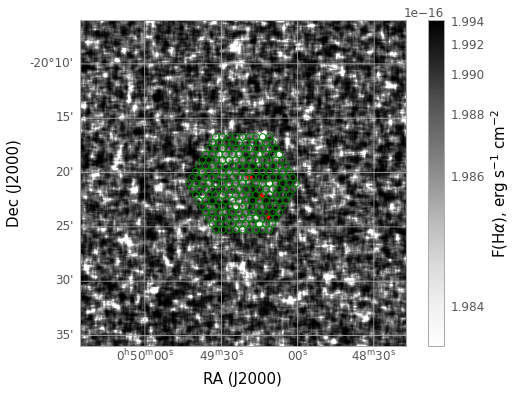

In [34]:
my_lvmfield.show(cmap=plt.cm.Greys, percentile=96, fibers=bundle.fibers)

#### Positioning the nebulae

Let's add now another two nebulae, but this time simultaneously, as a list of dictionaries. One of them will be ``Rectangle``, another - ``Ellipse``. Both these nebulae by have uniform distribution of the surface brightness and constant line ratios.

In contrast with DIG, these nebulae have limited size, and thus we need to define their position in the FOV. This can be done in several ways:
- providing parameters `X` and `Y` (or `RA` and `DEC`), which define the position of the central pixel in the FOV (in pixels or in RA-DEC)
- providing offsets along X and Y axes (or along RA and DEC). Offsets along X and Y should be in pixels, while along RA and DEC in arcsec (or any other angular units). Note that positive value of `offset_RA` will shift the nebula to the left (towards the higher RA).

When you use several nebulae in the FOV, you may want to define in which order they are located along the line of sight. This is useful if you want to simulate the situation when there is a dark cloud on the line of sight that is absorbing part of the light from the background nebulae (and produce the reddening of the spectra). This can be done with the parameter ``zorder``. By default, this is equal to -1 for ``DIG`` and to 0 for all other nebulae. Lower value means that the object is further along the line of sight from the observer.

By default, the method ``add_nebulae`` will overwrite the ISM content that has been early attached to the FOV. To avoid this, don't forget to use the parameter ``overwrite=False``.


In [66]:
my_nebulae = [{'type': 'Rectangle', 'offset_RA': 120.*u.arcsec, 'offset_DEC': -50.*u.arcsec, 'width': 90 * u.pc, 'height': 60 * u.pc, 'max_brightness': 7e-16, 'zorder': 2},
              {'type': 'Ellipse', 'offset_X': -150, 'offset_Y': 300, 'ax_ratio': 0.5, 'PA': 20, 'radius': 100 * u.pc, 'distance': 150 * u.kpc,
               'max_brightness': 1e-15},
              ]
my_lvmfield.add_nebulae(my_nebulae, overwrite=False)

[INFO]: Start generating 2 nebulae
  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #0: use default 'cloudy_id=Cloud_366'
 50% (1 of 2) |#############             | Elapsed Time: 0:00:02 ETA:   0:00:02[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #1: use default 'cloudy_id=Cloud_366'
100% (2 of 2) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


Note that we set up the ``distance`` to the ``Ellipse`` nebula different from that was used for the ISM. That is why the physical pixel scale for this nebula is different and thus it has smaller angular size on the image even despite it has larger physical size than ``Rectangle``.

[WARNING]: Bundle center coords are not defined, using the coords of the field.


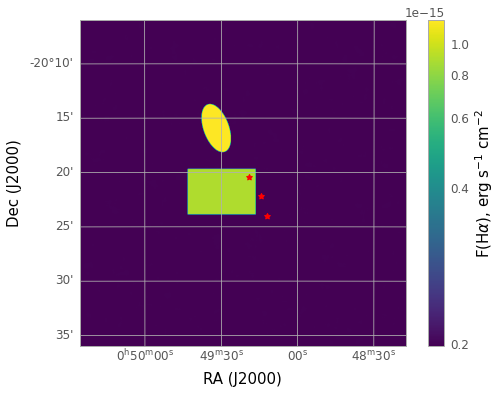

In [67]:
my_lvmfield.show(cmap=plt.cm.viridis, percentile=99)

The offsets of each nebulae in FOV can be easily adjusted. Here ``nebula_id`` starts from 0 and corresponds to the number of the nebula as it was added to FOV, ``offset`` is along X and Y, and units can be either angular or pixels (default). Let's shift the ``Ellipse``

[WARNING]: Bundle center coords are not defined, using the coords of the field.


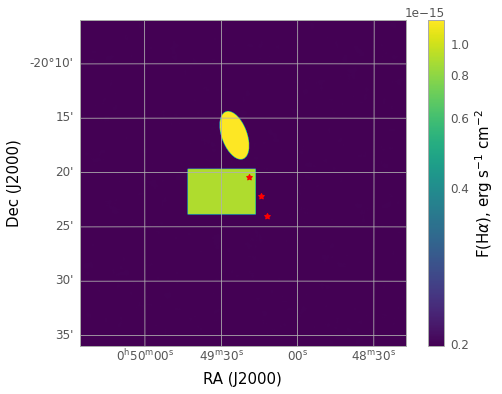

In [68]:
my_lvmfield.shift_nebula(nebula_id=2, offset=(100., -40.), units=(u.arcsec, u.arcsec))
my_lvmfield.show(cmap=plt.cm.viridis, percentile=99)

#### Nebulae with continuum and extinction

Let's add three more nebulae. Now we want to generate the object with non-uniform distribution of the brightness. For example, ``Galaxy``, which brightness is defined by the Sersic profile, and long and thin ``Filament`` representing a cylinder. Also we set up these object to emit in continuum, and the ``Galaxy`` will not emit emission lines (``max_brighness = 0`` or not defined).

The continuum shape can be set up in four ways:
- ``continuum_type = 'BB'``: SED corresponds to the black-body with $T_eff$ equal to the parameter ``continuum_data``.
- ``continuum_type = 'poly'``: SED is defined as polynomial with coefficients in ``continuum_data``.
- ``continuum_type = 'model``:
    - if ``continuum_data`` is a dictionary having keys ``wl`` and ``flux`` (numpy arrays or lists), then these values define the continuum that will be interpolated to the regular wavelenght grid.
    - if ``continuum_data`` is an int number, then it corresponds to the ID of the pre-defined Starburst99 model.

Flux normalization of continuum is defined in the following way. Either ``continuum_mag`` or ``continuum_flux`` should be provided. In the first case ``continuum_wl`` should be equal to one of the allowed filters (B, V, R, I, sdss_g, sdss_r, sdss_i). Then the ``continuum_mag`` corresponds to the magnitude in that filter. If ``continuum_flux`` is provided, then it is assumed to be the flux density at the wavelength defined in ``continuum_wl`` (in Angstrom)

Third object will be a dark ``Circle`` that doesn't emit anything, but contains absorbing dust that is defined by the ``max_extinction`` property (corresponds to $A_V$ in magnitudes)

**Note: every nebula can be either dark or emitting. But any of them can have continuum.**

In [69]:
my_nebulae = [ {'type': 'Galaxy', 'offset_X': 220, 'offset_Y': -250, 'distance': 10*u.Mpc,
               'r_eff': 10 * u.kpc, 'rad_lim': 5., 'n': 1.5, 'ax_ratio': 0.7, 'PA': 35 * u.degree, 'vel_rot': 90,
               'continuum_type': 'model', 'continuum_data': 3, 'continuum_mag': 22*u.mag, 'continuum_wl': 'V'},
              {'type': 'Filament', 'offset_RA': -105., 'offset_DEC': 160.,
               'length': 100 * u.pc, 'width': 8*u.pc, 'PA': -65 * u.degree,
               'max_brightness': 3e-16, 'continuum_type': 'BB', 'continuum_data': 35000, 'continuum_flux': 1e-16, 'continuum_wl': 5500},
               {'type': 'Circle', 'offset_RA': -4., 'offset_DEC': 15.,
               'radius': 40 * u.pc, 'max_extinction': 2 * u.mag},
              ]
my_lvmfield.add_nebulae(my_nebulae, overwrite=False)

[INFO]: Start generating 3 nebulae
 33% (1 of 3) |########                  | Elapsed Time: 0:00:03 ETA:   0:00:06[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #1: use default 'cloudy_id=Cloud_366'
100% (3 of 3) |##########################| Elapsed Time: 0:00:05 Time:  0:00:05


[WARNING]: Bundle center coords are not defined, using the coords of the field.


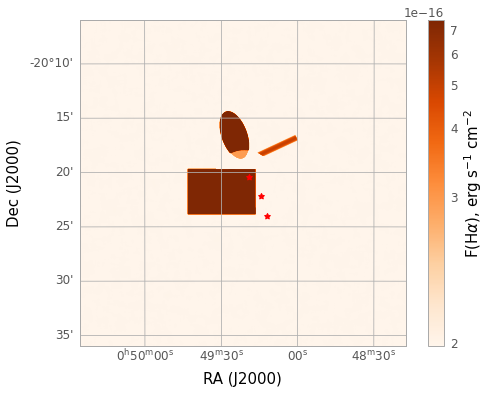

In [70]:
my_lvmfield.show(percentile=95)

One may notice few things on the top image:
- The ``Ellipse`` is extincted, but the ``Rectangle`` is not. This is because of the mentioned earlier parameter ``zorder``. All nebulae are sorted according to that, and only those nebulae with ``zorder`` less than ``zorder`` for the dark cloud are processed. Since the ``Rectangle`` has ``zorder=2``, it is assumed to be located closer to us along the line of sight, and thus the extinction does not affect it.
- **Note that extinction doesn't affect the stars in this version of the code. Also, at the moment there is some bug in the code, and zorder works incorrectly for saving the fits-files with the images. The latter will be fixed soon**
- ``Galaxy`` is not visible! This is because by default the displayed image is the pure Halpha line, and this Galaxy has no associated emission spectrum. To see it, we can first produce the new map - in the broader wavelength range. It will be also automatically saved as fits-file in your work directory.

[INFO]: Input image in 6560.0-6565.0AA wavelength range is saved to LVM_simple_example_6560_6565_input_map.fits
[WARNING]: Bundle center coords are not defined, using the coords of the field.


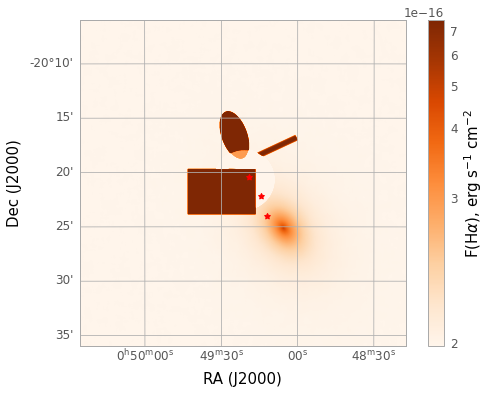

In [71]:
my_lvmfield.get_map(wavelength_ranges=[6560, 6565])
my_lvmfield.show(percentile=95)

Note: you can check the available ID of the SB99 models as follows:

In [46]:
from lvmdatasimulator.utils import models_grid_summary
tab = models_grid_summary('continuum')
tab.pprint_all()

 ID     Name                                     Description                                  
--- ----------- ------------------------------------------------------------------------------
  0   Z0.040_t1   Starburst99: Z=0.040, age=1Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  1   Z0.040_t2   Starburst99: Z=0.040, age=2Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  2   Z0.040_t3   Starburst99: Z=0.040, age=3Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  3   Z0.040_t4   Starburst99: Z=0.040, age=4Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  4   Z0.040_t5   Starburst99: Z=0.040, age=5Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  5   Z0.040_t6   Starburst99: Z=0.040, age=6Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  6   Z0.040_t7   Starburst99: Z=0.040, age=7Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  7   Z0.040_t8   Starburst99: Z=0.040, age=8Myr, M=1e6, inst, IMF_alpha=2.35, Mup=100, Mlow=1
  8   Z0.040_t9   Starburst99: Z=0.040, age=9Myr, 

#### Save ISM content
The produced ISM content can be saved to the fits file. We will describe soon (in README) how the nebular content is organized in this file

In [24]:
my_lvmfield.save_ism("testneb_tutorial2_ex1.fits")

[INFO]: Generated ISM saved to ./testneb_tutorial2_ex1.fits
[INFO]: ISM content saved to testneb_tutorial2_ex1.fits


### Step 3. Run simulations
If needed, you can load previously saved region to process it further with simulator. Don't forget to load the stars as well!

In [72]:
my_lvmfield.add_nebulae(load_from_file="testneb_tutorial2_ex1.fits")
my_lvmfield.open_starlist('LVM_simple_example_starlist.fits.gz')

[INFO]: Nebulae successfully loaded from file


Now it is time to "observe" our sources. Necessary instrumental setup is already initialized, the only remaining part is ``Observation``
For that, we should define exposure time (or several exposure times, in seconds) and the same RA and DEC that were used to create source field.
**N.B.: in the current version we simulate only single exposures (not combined)**
Then we initialize the ``Simulator`` which combines all components

In [73]:
exptimes = [900, 10 * 900] # in seconds
obs = Observation(ra=ra, dec=dec, unit_ra=u.deg, unit_dec=u.deg, exptimes=exptimes)
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)

Everything is ready now. Let's go!
The simulator will extract the spectra in each fiber from each nebula (and stars), add sky and readout noise. It takes longer for more extended nebulae (e.g. DIG), or if the nebula has varying LSF or line fluxes (see Example 2). In our example, the spectra extraction and interpolation to the instrument wavelength grid should last in about 1 minute (on laptop)

In [74]:
sim.simulate_observations()
sim.save_outputs()

[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /Users/mors/Science/PyWorkspace/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 217 fibers.
[INFO]: Start extracting nebular spectra
  0% (0 of 6) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[INFO]: Convolving the whole array at once
 16% (1 of 6) |####                      | Elapsed Time: 0:00:55 ETA:   0:04:35[INFO]: Convolving the whole array at once
 33% (2 of 6) |########                  | Elapsed Time: 0:01:04 ETA:   0:00:36[INFO]: Convolving the whole array at once
 50% (3 of 6) |#############             | Elapsed Time: 0:01:05 ETA:   0:00:15[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at on

The resulting spectra for each exposure time are available now in the working directory. The content of the files will be considered in the next tutorial. But let's briefly see how this looks like

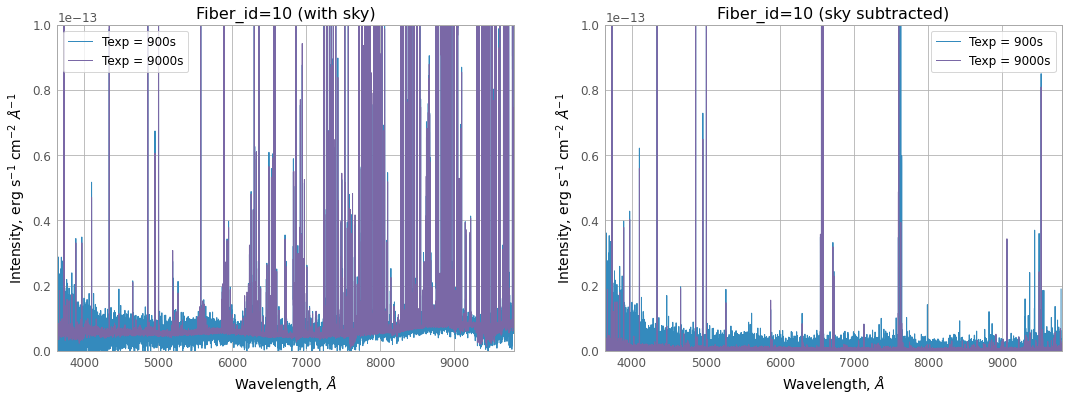

In [75]:
fig = plt.figure(figsize=(18,6))
fiber_id = 10
with fits.open(f"outputs/LVM_simple_example_linear_full_{exptimes[0]}_flux.fits") as hdu:
    wave = hdu['Wave'].data
    flux_short_exp = hdu['TOTAL'].data[fiber_id]
    flux_short_exp_nosky = hdu['TARGET'].data[fiber_id]
with fits.open(f"outputs/LVM_simple_example_linear_full_{exptimes[1]}_flux.fits") as hdu:
    flux_large_exp = hdu['TOTAL'].data[fiber_id]
    flux_large_exp_nosky = hdu['TARGET'].data[fiber_id]
ax = plt.subplot(121)
plt.plot(wave, flux_short_exp, linewidth=1, label=f"Texp = {exptimes[0]}s")
plt.plot(wave, flux_large_exp, linewidth=1, label=f'Texp = {exptimes[1]}s')
plt.legend()
plt.xlabel("Wavelength, $\AA$",fontsize=14)
plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
plt.ylim(0,1e-13)
plt.xlim(3640,9810)
plt.title(f"Fiber_id={fiber_id} (with sky)", fontsize=16)

ax = plt.subplot(122)
plt.plot(wave, flux_short_exp_nosky, linewidth=1, label=f"Texp = {exptimes[0]}s")
plt.plot(wave, flux_large_exp_nosky, linewidth=1, label=f'Texp = {exptimes[1]}s')
plt.legend()
plt.xlabel("Wavelength, $\AA$",fontsize=14)
plt.ylabel("Intensity, erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$",fontsize=14)
plt.ylim(0,1e-13)
plt.xlim(3640,9810)
plt.title(f"Fiber_id={fiber_id} (sky subtracted)", fontsize=16);

Now we want to save also the resulting map and to compare it with the input map.

In [76]:
sim.save_output_maps(wavelength_ranges=[6560, 6565])

[INFO]: Saving the 2D output maps
[INFO]:  Saving ./outputs/LVM_simple_example_linear_full_6560_6565_900s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_simple_example_linear_full_6560_6565_900s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_simple_example_linear_full_6560_6565_9000s_target_map.fits...
[INFO]:  Saving ./outputs/LVM_simple_example_linear_full_6560_6565_9000s_total_map.fits...
[INFO]:  Saving ./outputs/LVM_simple_example_fibers.reg...


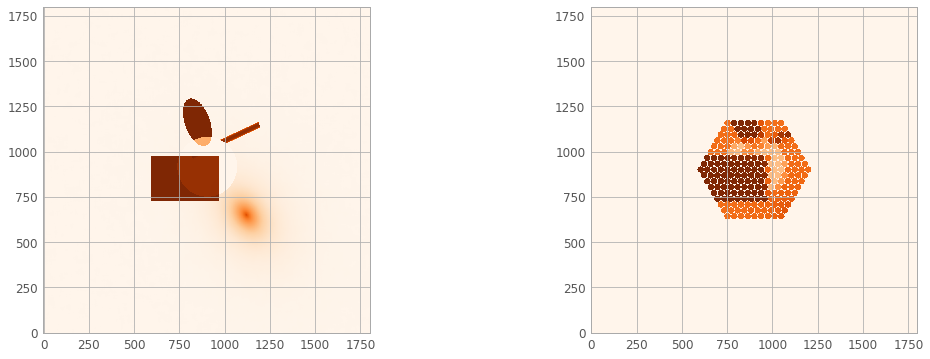

In [77]:
fig = plt.figure(figsize=(18,6))
ax=plt.subplot(121)
with fits.open(f"LVM_simple_example_6560_6565_input_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data, stretch=AsinhStretch(), interval=PercentileInterval(96.))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)
ax=plt.subplot(122)
with fits.open(f"outputs/LVM_simple_example_linear_full_6560_6565_{exptimes[1]}s_total_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data, stretch=AsinhStretch(), interval=PercentileInterval(96.))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)

## Example 2: Simulate nebulae with varying line ratios and kinematics
In this example we will consider more complex types of the nebulae. Currently, only ``Cloud`` and ``Bubble`` allow the variations of the line ratios with the position in the nebulae (namely, radial variations). The main difference between them is that ``Cloud`` is a filled sphere, while ``Bubble`` has a limited thickness (defined by parameter ``thickness`` [default=0.2]).
The simulator uses the pre-generated Cloudy models to produce the emission spectra. As well as the continuum Starburst99 models, these are stored in the ``data`` directory (in the form of multi-extensions fits-file). The structure of this file is quite specific and will be soon described in details in ``README``. However, it might be important to know few things:
- Each extension corresponds to particular set of the parameters of the nebula and ionizing source. There are models for integrated spectrum of the nebula, as well as the radial distribution of each line. The integrated spectra are used for all nebulae by default except ``Cloud`` and ``Bubble`` - for them we use the radial distribution. If one needs to generate one of these objects with the constant line ratio, they can add key ``linerat_constant = True`` to the dictionary describing the nebula.
- There are two types of models - roughly, produced for shells and clouds. Latter assume that the nebulae have inner radius close to zero, while $R_{in}=10 pc$ was assumed to produce the shell-like geometry models. We recommend to use them for ``Bubble`` nebulae, while those with the cloud geometry are fine for all other nebulae. The radial distribution of the line fluxes in the simulator is produced as follows:
    - The whole radial extent of the nebula is normalized to the range [0,1], where 0 corresponds to the inner wall (or to the center, if it is a ``Cloud``), and 1 - to the outer edge.
    - Same is also performed for the radial extent of the selected Cloudy model
    - Then the Cloudy model interpolated to the radial extend of the nebulae according to these calculated relative normalized positions
- To select the desired Cloudy model as a source of the emission line ratios, one can provide either the parameter ``cloudy_id`` (equal to the Cloudy ``Model_ID``), or the dictionary ``cloudy_params`` containing the information about the desired parameters of the model. In the latter case, the closest model will be selected, or the default one (if the input parameters doesn't limit the number of models).
- Parameters of the default model are given in the configuration file and can be changed.

It is possible to save your own grid of Cloudy models in the same format as used in the lvmdatasimulator. To do this, there is a function ``save_cloudy_models`` in the ``utils.py``

To get the summary of the available Cloudy models, do this (you can operate with this summary as with regular astropy.table):

In [79]:
from lvmdatasimulator.utils import models_grid_summary
tab = models_grid_summary()
tab

Model_ID,Geometry,Z,qH,LogLsun,Teff,nH,Rin,Rout,Nzones,Nlines,Distance,Flux_Ha,Source_model
str10,str5,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str43
Shell_1,Shell,0.8,50.3,6.5,50000.0,500.0,10.01,10.09,119,141,50.0,9.528778703652963e-10,LVM_Cloudy_z0.80_l6.5_t50000_n500.0_r10.0
Cloud_1,Cloud,1.0,49.7,6.0,40000.0,500.0,0.01,1.67,230,141,50.0,2.425748569407134e-10,LVM_Cloudy_z1.00_l6.0_t40000_n500.0_r0.0
Cloud_2,Cloud,0.8,49.8,6.0,120000.0,100.0,0.01,6.25,320,141,50.0,3.1211451946697835e-10,LVM_Cloudy_z0.80_l6.0_t120000_n100.0_r0.0
Shell_2,Shell,0.2,48.4,4.5,60000.0,100.0,10.01,10.08,123,141,50.0,1.0449082651998981e-11,LVM_Cloudy_z0.20_l4.5_t60000_n100.0_r10.0
Cloud_3,Cloud,0.6,48.7,5.5,25000.0,30.0,0.01,5.1,240,141,50.0,2.500678347117836e-11,LVM_Cloudy_z0.60_l5.5_t25000_n30.0_r0.0
Cloud_4,Cloud,0.4,48.1,4.5,35000.0,100.0,0.01,1.54,228,141,50.0,6.021576630112747e-12,LVM_Cloudy_z0.40_l4.5_t35000_n100.0_r0.0
Cloud_5,Cloud,0.6,51.0,7.5,30000.0,100.0,0.01,13.14,296,141,50.0,4.359351204470388e-09,LVM_Cloudy_z0.60_l7.5_t30000_n100.0_r0.0
Cloud_6,Cloud,0.4,50.2,6.5,40000.0,100.0,0.01,7.7,281,141,50.0,7.483808065868175e-10,LVM_Cloudy_z0.40_l6.5_t40000_n100.0_r0.0
Cloud_7,Cloud,1.0,51.3,7.5,50000.0,100.0,0.01,16.8,311,141,50.0,9.79130036450541e-09,LVM_Cloudy_z1.00_l7.5_t50000_n100.0_r0.0


Let's create now a new source field. But before we should create a new LVMField. Also, since now we want to trace the gas kinematics, it might be useful to set parameter ``preserve_kinematics = True``. **However, at the moment we will continue to use ``preserve_kinematics = False`` since otherwise it will significantly slow down computations of the ``Bubbles``. We will work on the improvements. If you don't simulate ``Bubles`` or ``Clouds`` - use ``preserve_kinematics = True``.**

Also we mention the usage of ``vel_amplitude`` keyword which defines the range of possible velocities relative to systemic velocity for all nebulae. By default, ``vel_amplitude = 150 *u.km/u/s``. **In this version of the code it is very important to make sure this value exceeds the possible range of the relative velocities in the line profiles of the nebulae (including the broadening, which is defined by ``turbulent_sigma``). Otherwise there will be problems during the spectra extraction**

In [15]:
my_lvmfield = LVMField(ra=ra, dec=dec, size=fov_size, spaxel=fov_pixel, name='LVM_simple_example',
                       ism_params={'preserve_kinematics': False, 'vel_amplitude': 150.})

We start with adding the DIG, but this time we want to make sure the line ratios for this correspond to, say, some moderate luminosity source of ionization with low temperature, low density and metallicity equal to Z=0.6Zsun. Looking at the table above, we find that ``Model_ID = 'Cloud_3'`` pass these criteria.

Also, we may want to limit the number of the lines to use in the output. By default, simulator use 141 emission lines (depends on the pre-defined Cloudy models grid). Providing the keyword ``n_brightest_lines = 20`` will limit the spectra to 20 brightest lines. This might be very helpful to speed up the calculations if the fainter lines are not important.

In [16]:
dig = {"type": 'DIG', 'max_brightness': 2e-16, 'perturb_amplitude': 0.1, 'perturb_scale': 500 * u.pc,
       'n_brightest_lines': 20, 'cloudy_id': 'Cloud_3'}
my_lvmfield.add_nebulae(dig)

[INFO]: Start generating 1 nebulae
100% (1 of 1) |##########################| Elapsed Time: 0:00:04 Time:  0:00:04


Now we'll add Bubble object. Let's assume this is ionized by the source having $L=10^5L_\odot$ and $T_{eff}=65000 K$, the density is $n_H = 150 cm^{-3}$ and the metallicity is solar (note also that we will use the ``Sphere`` geometry). There is no such Cloudy model in our grid, but the code will select one with the closest parameters.

We also assume that this bubble has a different systemic velocity and also expanding with ``expansion_velocity = 30 * u.km/u.s``.

**N.B. Simulating the bubbles and clouds, we first compute their parameters in 4D grid, which makes the calculations very demanding to RAM. We are looking for the way how to simplify this, but for now - please avoid of adding big bubbles/clouds to your source field. For example, simulations of the Bubble with $R>25-30$ pc (at the default distance 50 kpc => angular size is a key here) might be painful if you want to do this on laptop.**

As computation of the bubbles might be expensive, we want to save the result right after it's ready. If you are unhappy with the further components, you can load this file and start the simulation from them.

[INFO]: Start generating 1 nebulae
  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[WARNING]: Use the closest pre-computed Cloudy model with id = Shell_349
100% (1 of 1) |##########################| Elapsed Time: 0:08:57 Time:  0:08:57
[INFO]: Generated ISM saved to ./testneb_tutorial2_ex2.fits
[INFO]: ISM content saved to testneb_tutorial2_ex2.fits
[WARNING]: Bundle center coords are not defined, using the coords of the field.


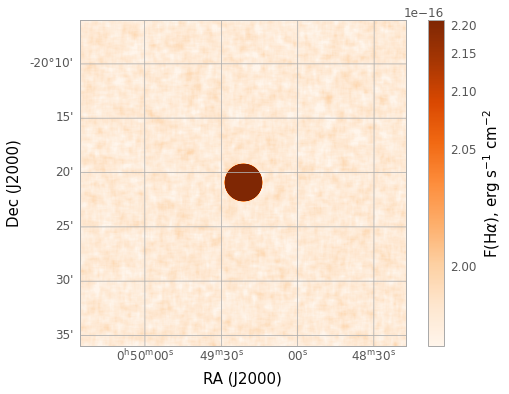

In [17]:
bubble = {'type': 'Bubble', 'max_brightness': 8e-16, 'thickness': 0.2, 'radius': 20, 'expansion_velocity': 30, 'sys_velocity': -50,
          'n_brightest_lines': 20, 'cloudy_params': {'Z': 1., 'Teff': 65000, 'LogLsun': 5., 'nH': 150, 'Geometry': 'Shell'},
          'offset_RA':0, 'offset_DEC':0}
my_lvmfield.add_nebulae(bubble, overwrite=False, save_nebulae='testneb_tutorial2_ex2.fits')
my_lvmfield.show(percentile=98)

Now we will add one background ``Galaxy`` with systemic velocity ``sys_velocity = 2000 u.km/u.s`` and rotating with the velocity ``vel_rot = 50*u.km/u.s``.
Also there will be one filament with the velocity gradient along it (you can set up it for any nebula except ``Bubble`` and ``Cloud`` using the parameter ``vel_gradient`` in units of km/s/pc). Also we make the line profile of the ``Filament`` slightly more broadened than other nebulae (e.g. because of the shocks).
In both cases by default the position angle of kinematic axis is the same as for the object. However, it can be changed using ``vel_pa``

In [57]:
my_lvmfield.add_nebulae(load_from_file='testneb_tutorial2_ex2.fits')

my_nebulae = [{'type': 'Galaxy', 'offset_RA': -180., 'offset_DEC': 180., 'distance': 15*u.Mpc,
               'r_eff': 10 * u.kpc, 'rad_lim': 5., 'n': 1.5, 'ax_ratio': 0.7, 'PA': 35 * u.degree,
               'max_brightness': 6e-16,'continuum_type': 'model', 'continuum_data': 60, 'continuum_mag': 22*u.mag, 'continuum_wl': 'R',
               'sys_velocity': 2000, 'vel_rot': 40},
              {'type': 'Filament', 'offset_RA': 70., 'offset_DEC': -280., 'length': 200*u.pc, 'width': 5 * u.pc,
               'PA': -60,
               'max_brightness': 1e-15,
               'turbulent_sigma': 40, 'vel_gradient': 0.7, 'vel_pa': -60}
              ]
my_lvmfield.add_nebulae(my_nebulae, overwrite=False)

[INFO]: Nebulae successfully loaded from file
[INFO]: Start generating 2 nebulae
  0% (0 of 2) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #0: use default 'cloudy_id=Cloud_366'
 50% (1 of 2) |#############             | Elapsed Time: 0:00:05 ETA:   0:00:05[WARNING]: Neither of 'cloudy_id' or 'cloudy_params' is set for the nebula #1: use default 'cloudy_id=Cloud_366'
100% (2 of 2) |##########################| Elapsed Time: 0:00:08 Time:  0:00:08


[WARNING]: Bundle center coords are not defined, using the coords of the field.


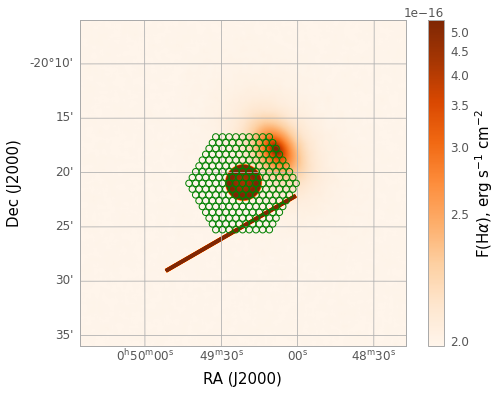

In [58]:
my_lvmfield.show(fibers=bundle.fibers)

Ok, now, once we are satisfied with the position of the other components, we want to overwrite the existing file and start the simulator

In [59]:
my_lvmfield.save_ism('testneb_tutorial2_ex2.fits')
my_lvmfield.get_map(wavelength_ranges=[6550, 6570])

[INFO]: Generated ISM saved to ./testneb_tutorial2_ex2.fits
[INFO]: ISM content saved to testneb_tutorial2_ex2.fits
[INFO]: Input image in 6550.0-6570.0AA wavelength range is saved to LVM_simple_example_6550_6570_input_map.fits


In [60]:
obs = Observation(ra=ra, dec=dec, exptimes=[900, 10*900])
sim = Simulator(my_lvmfield, obs, spec, bundle, tel)
sim.simulate_observations()
sim.save_outputs()
sim.save_output_maps(wavelength_ranges=[6550, 6570])

[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 2 days from new moon.
[INFO]: Using sky file: /Users/mors/Science/PyWorkspace/lvmdatasimulator/data/sky/LVM_LVM160_SKY_2.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 217 fibers.
[INFO]: Start extracting nebular spectra
  0% (0 of 4) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--[INFO]: Convolving the whole array at once
 25% (1 of 4) |######                    | Elapsed Time: 0:00:52 ETA:   0:02:36[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the whole array at once
[INFO]: Convolving the who

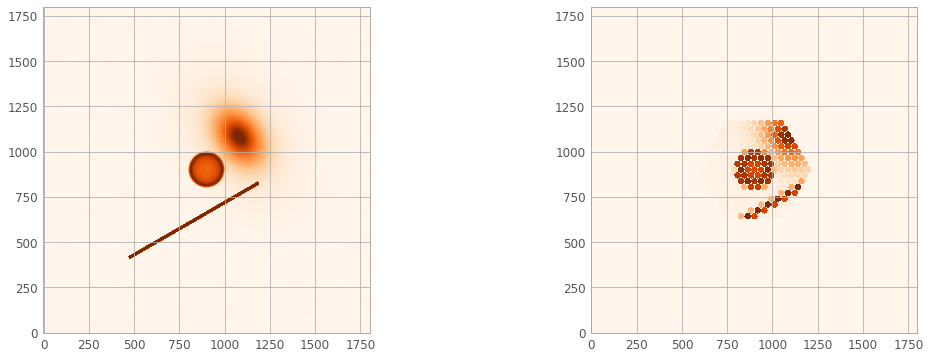

In [61]:
fig = plt.figure(figsize=(18,6))
ax=plt.subplot(121)
with fits.open(f"LVM_simple_example_6550_6570_input_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data, stretch=AsinhStretch(), interval=PercentileInterval(99.))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)
ax=plt.subplot(122)
with fits.open(f"outputs/LVM_simple_example_linear_full_6550_6570_9000s_total_map.fits") as hdu:
    norm = ImageNormalize(hdu[0].data[hdu[0].data > 0], stretch=AsinhStretch(), interval=PercentileInterval(99))
    ax.imshow(hdu[0].data, origin='lower', interpolation='nearest', cmap=plt.cm.Oranges, norm=norm)

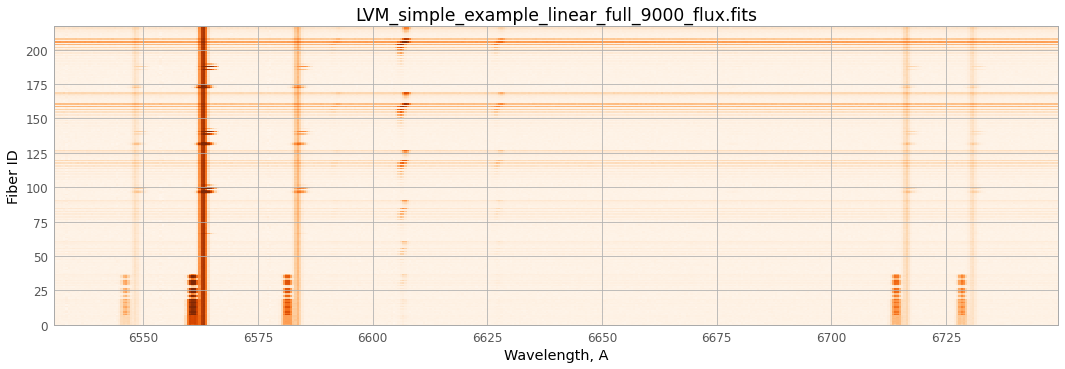

In [62]:
fig = plt.figure(figsize=(18,6))
ax=plt.subplot(111)
filename = 'LVM_simple_example_linear_full_9000_flux.fits'
with fits.open(f"outputs/{filename}") as hdu:
    wave = hdu['WAVE'].data
    select_wl = (wave > 6530) & (wave < 6750)
    norm = ImageNormalize(hdu['TARGET'].data[:, select_wl], stretch=AsinhStretch(), interval=PercentileInterval(99.9))
    ax.imshow(hdu['TARGET'].data[:, select_wl], origin='lower', interpolation='nearest', cmap=plt.cm.Oranges,
              norm=norm, extent=(wave[select_wl][0], wave[select_wl][-1], 0, hdu['TARGET'].data.shape[0]), aspect=0.3)
    ax.set_xlabel('Wavelength, A')
    ax.set_ylabel('Fiber ID')
    ax.set_title(filename)

As you can see, the velocity of the filament (illuminating several fibers) is indeed not uniform, and the line profile is broadened.
The velocity offset for bubble is also observed, as well as two-component line profile in its center (fibers ID ~0). However, such small expansion velocity results in rather broadening of the line profile than into its splitting onto the components - spectral and (in this case - more importantly) angular resolution is insufficient.
And the galaxy is definitely red-shifted and rotating.